# Task 1
I first eliminated the models not belonging to the category of ensemble methods. These were MLP, Gaussian NB, and LDA. I kept Random Forest, Gradient Boost, and XGB, because they all utilize ensemble learning methods. Then, I created a directory called kaggle. In this directory, I created a directory called input. In this directory, I uploaded the csv file containing all the data. I also had to use pip to install various libraries for the runtime. This allowed the notebook to run without manual intervention.

In [5]:
!pip install umap

In [6]:
!pip install pandas --upgrade

In [7]:
!pip install umap-learn

# Task 2A
A decision tree alone would not be a good choice for this problem. As noted in the textbook, a decision tree structure will most likely overfit the training data. Since it doesn't have a predetermined set of parameters, the model is free to stick closely to the data and is incentivized to do so. Decision trees also love orthogonal decision boundaries, making them sensitive to the data's orientation. Meanwhile, ensemble methods result in much smoother decision boundaries. Finally, decision trees have a high variance, meaning that changes in hyperparamters result in significantly different models. However, this variance can be reduced by using an ensemble of trees instead.

#Task 2B
A random forest is making the final determination of ship type by averaging the predictions from a set of weak learners - individual decision trees. This is done by creating a committee that makes uncorrelated mistakes. In other words, the trees are randomly different from each other. Otherwise, the performance would be equivalent to that of a single weak predictor. Within the constructor of the RandomForestClassifier, we can see a call to the parent constructor (ForestClassifier), passing in the hyperparameters as well as defining the estimator to be DecisionTreeClassifiers. If we look at the ForestClassifier class, it contains a method called predict that is inherited by the RandomForestClassifier. In this method, we can see the predictions being made by a method called predict_proba that predicts the mean class probabilities of all the trees in the forest for the input. After making these predictions, the argmax of them is taken and returned. Finally, taking a closer look at the predict_proba method, it is shown that threading is utilized to parallelize the computation of the probabilities for all the estimators before returning the average. Pulled from the course site, the most relevant equation in this context is the forest class's posterior, which is the average of all tree posteriors:
$$p(c|\mathbf x) = \frac{1}{T} \sum_{t=1}^T p_t(c|\mathbf x)$$
In this equation, T reperesents the total number of weak learners.


#Task 3A
CV, or cross validation, allows us to compare different machine learning methods. We break up data into training data and testing data. Training data allows us to estimate model paramters. Testing data allows us to evaluate how well our learning method worked. Cross validation is the practice of changing which subset of the data is used for testing purposes each time the model is trained and summarizing these results. For example, if we used 25% of the data for testing, we will use the first 25%, then the second 25%, then the third 25%, and finally the fourth 25%. CV is useful for many reasons. By training the model on various subsets of the data, cross validation mitigates overfitting, makes better use of the available data, and evaluates how well a learning algorithm performs on a given dataset. It can even be used to help tune hyperparamters.

#Task 3b
In order to include boostrapping, I instantiated a RandomForestClassifier with the bootstrap parameter set to True within the list of classifiers. Therefore, in the loop that does paramter estimation, output prediction, and model evaluation, the bootstrapped model is also included. As we can see in the diagrams produced, bootstrapping has very similar performance to that of CV. However, it produces slightly better results.

# Task 4
The feature importance ranking was obtained from the RandomForestClassifier object with the tuned hyperparameters after it was fitted/trained. This was done by simply accessing the feature_importances_ attribute of the object, placing it into a Pandas series, and plotting it. Looking into how it works, the object fits this attribute by measuring how much each feature contributes to reducing the entropy within each of the individual trees in the random forest and aggregating this data. More entropy reduction results in higher feature importance.

#Task 5
At the end of this notebook, I utilized the lightGBM library to train the model on the given dataset with its hyperparameters tuned with Optuna. I agree that Random Forest perofmrs better than Gradient Boosting as the Random Forest classifier's accuracy is about 0.63 while the Gradient Boosting classifier's accuracy is less. I tuned the following hyperparameters: n_estimators, learning_rate, num_leaves, and max_depth. n_estimators specifies how many weak learners will be created as part of the ensemble. learning_rate controls how much a weak learner contributes to the boosting process. num_leaves specifies the maximum number of leaves each decision tree may have. Leaves are where predictions are made. Finally, max_depth represents the maximum depth of each decision tree or how may layers it may have.

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pandas as pd
import numpy as np
from typing import Any, Optional
import matplotlib.pyplot as plt
import seaborn as sns
import time
import umap
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV, GroupKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb



# Set style for the plots
sns.set(style='darkgrid')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
df = pd.read_csv(os.path.join("kaggle/input", "ais_data.csv"))
display(df.head())
display(df.tail())

,Unnamed: 0,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught
0,0,219019621,Unknown value,0.0,86.0,86.0,Fishing,4.0,9.0,NaN
1,1,265628170,Unknown value,0.0,334.5,NaN,Port tender,8.0,27.0,NaN
2,2,219005719,Unknown value,0.0,208.7,NaN,Fishing,4.0,11.0,NaN
3,3,219028066,Unknown value,0.0,NaN,NaN,Pleasure,3.0,12.0,NaN
4,4,212584000,Moored,0.0,153.0,106.0,Cargo,13.0,99.0,6.3


,Unnamed: 0,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught
358346,387577,236125000,Under way using engine,11.0,171.9,169.0,Cargo,12.0,82.0,4.2
358347,387578,209717000,Under way using engine,16.6,341.6,343.0,Cargo,27.0,170.0,8.9
358348,387579,257182000,Under way using engine,20.6,340.7,341.0,Passenger,36.0,224.0,6.9
358349,387580,219007697,Unknown value,34.9,96.2,NaN,Pilot,3.0,7.0,NaN
358350,387581,261054050,Under way using engine,11.5,315.0,310.0,Fishing,8.0,32.0,6.0


We can drop first column as it is clear it was created when resetting index, or saving csv without removing it.

In [10]:
df = df.iloc[:,1:]

In [11]:
df.drop(['mmsi'], axis=1).describe()

,sog,cog,heading,width,length,draught
count,357893.000000,355182.000000,337737.000000,354640.000000,354608.000000,332808.000000
mean,12.122554,189.064529,190.076829,19.947854,124.971549,6.571402
std,9.355851,107.588825,107.107604,10.808627,71.268183,2.934392
min,0.000000,0.000000,0.000000,1.000000,2.000000,0.400000
25%,9.200000,116.300000,120.000000,12.000000,83.000000,4.600000
50%,11.300000,168.700000,170.000000,17.000000,115.000000,6.100000
75%,13.300000,300.175000,303.000000,28.000000,181.000000,7.900000
max,214.000000,359.900000,507.000000,78.000000,690.000000,25.500000


Above table shows that their are some clear outliers with sog, length and draught

Having both width and length allows us to add an additional variable (area), with the only caveat being that the length and width were likely taken at the maximum points

In [12]:
df['area'] = df.width * df.length

## Missing values

In [13]:
pd.DataFrame(df.isna().sum())

,0
mmsi,0
navigationalstatus,0
sog,458
cog,3169
heading,20614
shiptype,0
width,3711
length,3743
draught,25543
area,3773


In [14]:
print(f"Proportion of null value rows: {round(len(df[df.isnull().any(axis=1)]) / len(df)*100)}%")

Proportion of null value rows: 9%


Null values account for approximately 9% of the data. A high proportion of missing values in the static variables. So, providing we have this information for the same vessels from another journey, then we should be able to imput these values.

In [15]:
static_vars = ['length', 'width', 'draught', 'area']

for var in static_vars:
    df[var] = df[['mmsi', var]].groupby('mmsi').transform(lambda x: x.fillna(x.median()))

With this imputation, we have been able to fill a good amount of the ships dimensions variables.

We should also include navigational status Unknown values within this as these have been logged as a string opposed to null values. Although we may not remove them, it is good to understand the quantity.


In [16]:
pd.DataFrame(df.navigationalstatus.value_counts())

,count
navigationalstatus,
Under way using engine,307581
Unknown value,17259
Constrained by her draught,12287
Engaged in fishing,10798
Moored,4121
Reserved for future amendment [HSC],1872
Restricted maneuverability,1868
Under way sailing,1396
At anchor,513


In [17]:
# Check to see how the missing values are split between the ship types as a proportion.
missing_ship_count = pd.DataFrame(df[df.isnull().any(axis=1)].shiptype.value_counts()).reset_index()
ship_count = pd.DataFrame(df.shiptype.value_counts()).reset_index()

missing_ship_count = missing_ship_count.merge(ship_count, on='shiptype', how='left')
#missing_ship_count['count_after_dropping'] = missing_ship_count.count_y - missing_ship_count.count_x
#missing_ship_count['proportion_missing'] = missing_ship_count.count_x/missing_ship_count.count_y

missing_ship_count = missing_ship_count.rename(columns={'count_x':'count_null', 'count_y': 'count'})

#missing_ship_count.sort_values(by='proportion_missing', ascending=False)

Based on the above table, we may consider dropping ship types Pleasure and Port tender due to having both high proportion missing as well as a limited number of data points once null values would be removed. It is also noted that this would be further reduced when considering both cross validation as well as removing a proportion of these to be used in a serving set for secondary validation. If we chose to keep these variables, it will be important to mention the caveat that predictions made on these ship types should be treat with caution due to limited number of data points.

It is also noted that there is a significant imbalance in the classes, therefore this will need to be considered when choosing the performance metric as well as traiing the model(s)

In [18]:
# Drop nulls
df = df.dropna()

## Checking duplicates

In [19]:
print(f"Number of rows with identical values in all variables: {len(df[df.duplicated()])}")

Number of rows with identical values in all variables: 2904


Quite a high proportion of duplicate rows. Are these duplicates or just different ships with identical values?

In [20]:
Quite a high proportion of duplicate rows. Are these duplicates or just different ships with identical values?

Object `values` not found.


In [21]:
display(df[df.duplicated(keep='first')].sort_values(by=list(df.columns)))

pd.DataFrame(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).shiptype.value_counts())

,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,area
71351,205688000,Under way using engine,9.8,221.0,220.0,Cargo,12.0,83.0,5.0,996.0
227087,205770000,Under way using engine,14.0,34.0,34.0,Tanker,17.0,97.0,5.1,1649.0
128138,209114000,Moored,0.0,291.6,282.0,Cargo,12.0,89.0,4.3,1068.0
255843,209114000,Under way using engine,7.0,165.1,163.0,Cargo,12.0,89.0,4.6,1068.0
116931,209114000,Under way using engine,8.2,325.1,325.0,Cargo,12.0,89.0,4.3,1068.0
...,...,...,...,...,...,...,...,...,...,...
1429,664288000,Under way using engine,15.3,340.0,340.0,Tanker,28.0,185.0,10.5,5180.0
32543,664445000,Under way using engine,12.3,34.5,35.0,Tanker,32.0,189.0,9.5,6048.0
33530,664445000,Under way using engine,12.5,339.4,339.0,Tanker,32.0,189.0,9.5,6048.0
184528,664445000,Under way using engine,14.0,24.5,25.0,Tanker,32.0,189.0,10.7,6048.0


,count
shiptype,
Cargo,3025
Tanker,1894
Passenger,311
Tug,100
Dredging,97
Military,74
HSC,69
SAR,38
Fishing,22


Nothing jumps out with regards to certain variables being able to explain these duplications.
In case this are actual duplications opposed to similar ships, these are removed from the data to avoid falsely inflating the accuracy of the model(s).

In [22]:
df = df.drop_duplicates()

In [23]:
len(df)

324561

# Exploratory Data Analysis

In [24]:
print(f"Number of unique vessels: {df.mmsi.nunique()}")

Number of unique vessels: 2799


Although we have a large number of rows, the actual number of unique vessels is 2799. For the modelling, we have 2 choices:
- Group by mmsi and then create aggregated variables, or
- Use grouped k fold when validating (ensuring that the same mmsi id is not in both train and test)

We can test which option will be the most appropriate by seeing if the dynamic variables vary much for each vessel (mmsi)

In [25]:
dynamic_vars = ['mmsi', 'sog', 'cog', 'heading']

df[dynamic_vars].groupby('mmsi').agg(
    sog_std = ('sog', 'std'),
    cog_std = ('cog', 'std'),
    heading_std = ('heading', 'std'),
).dropna()

,sog_std,cog_std,heading_std
mmsi,,,
205104000,1.785275,110.797995,110.102214
205209000,2.267307,120.775293,119.890407
205211000,2.554713,119.040468,119.216727
205212000,2.896524,117.348181,121.299998
205465000,1.545513,116.815861,130.592347
...,...,...,...
657246900,1.208701,52.226815,46.098415
664288000,1.316891,123.733167,123.701049
664444000,1.496389,113.060527,113.282904


We can see from the above table that there is variation and therefore we should choose the second option (keep all the rows and use grouped k fold) and have the model learn from this higher resolution data. However, the model training process will take signficantly longer due to the large number of data points.

## Analysis into the outliers

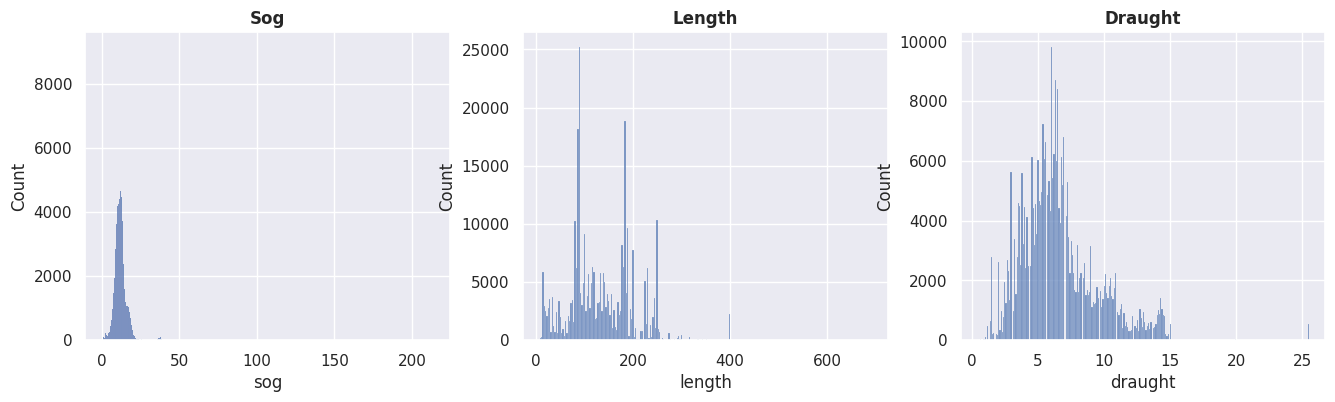

In [26]:
outlier_cols = ['sog', 'length', 'draught']

fig, axes = plt.subplots(1, 3, figsize=(16,4))

for i, col in enumerate(outlier_cols):
    ax1 = sns.histplot(df[col], ax=axes[i])
    ax1.set_title(col.capitalize(), weight='bold')


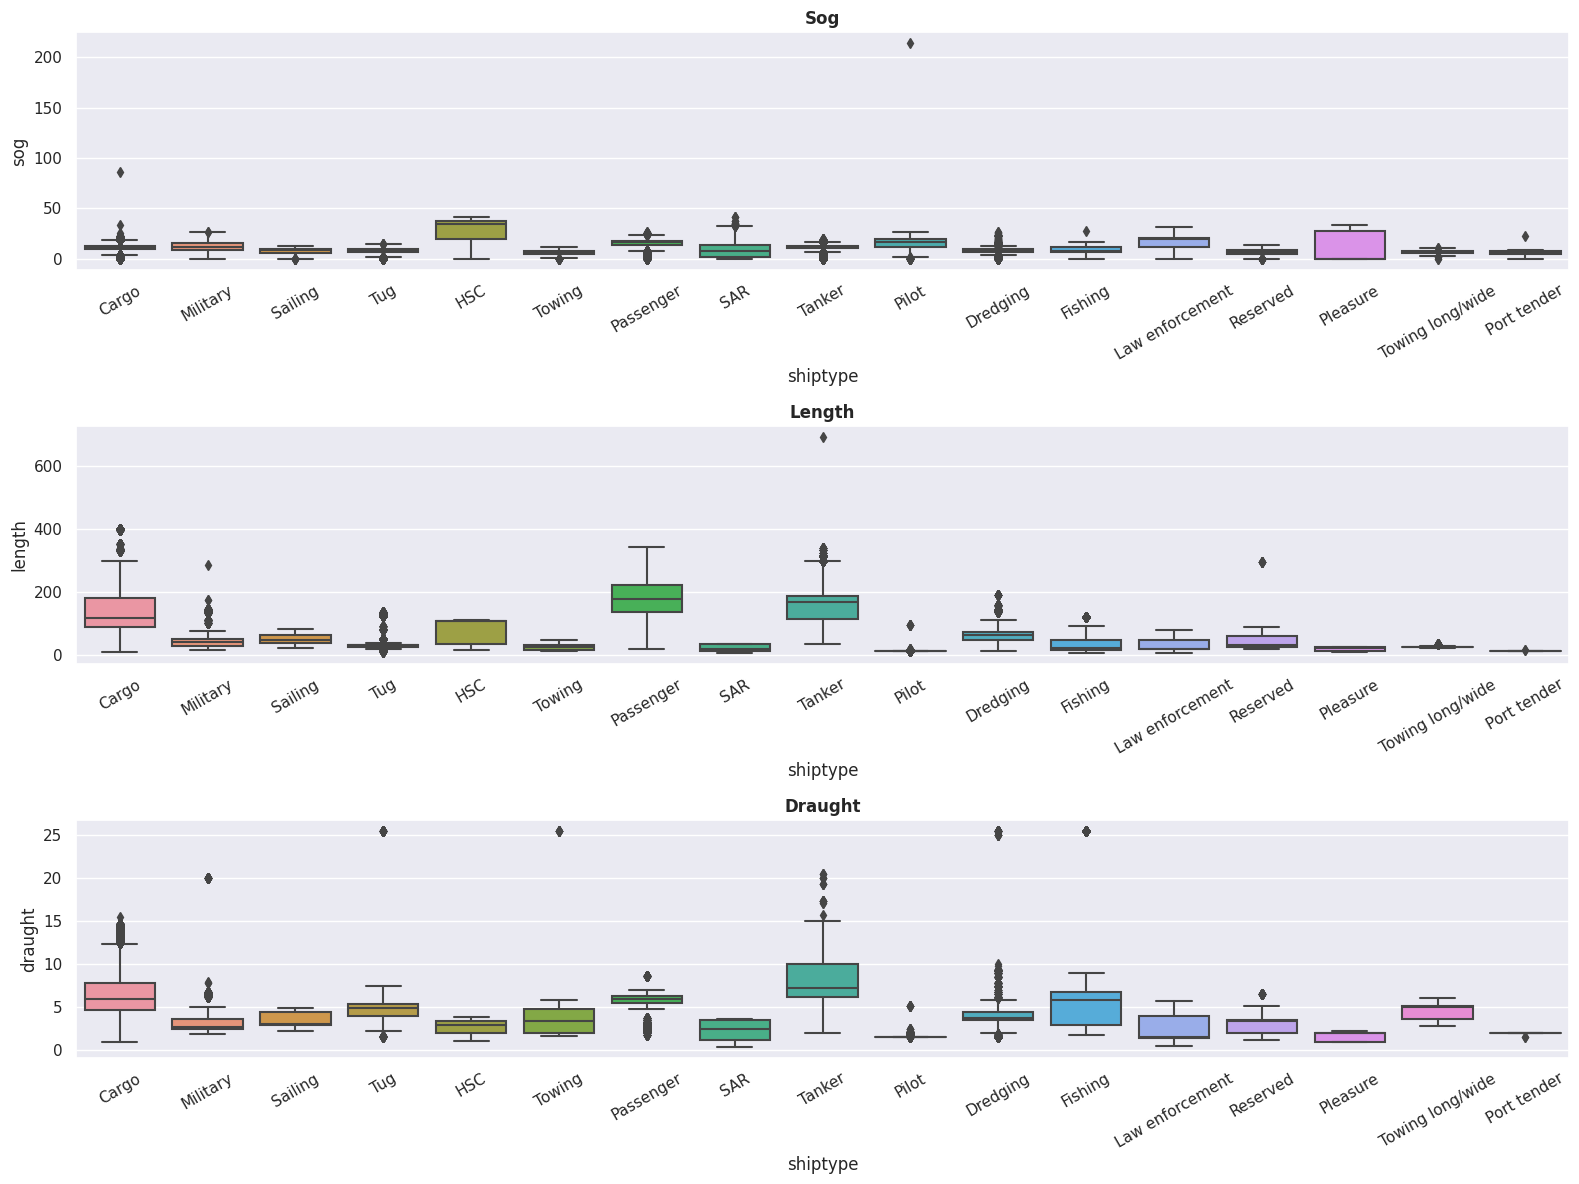

In [27]:
fig, axes = plt.subplots(3, 1, figsize=(16,12))


for i, col in enumerate(outlier_cols):
    ax = sns.boxplot(data=df, x='shiptype', y=col, ax=axes[i])
    ax.set_title(col.capitalize(), weight='bold')
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
plt.tight_layout()

In [28]:
# Potential rows to remove
df[(df.sog>200)|(df.length>500)]

,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,area
76551,211422510,Under way using engine,13.9,134.5,133.0,Tanker,28.0,690.0,6.8,19320.0
330195,219023648,Under way using engine,214.0,343.7,356.0,Pilot,5.0,15.0,1.5,75.0


Above boxplots illustrates some major outliers in each of the 3 variables.

One of the (what appears to be) obvious errors would be the Pilot ship type having a speed over ground of over 200 knots. In addition to this, assuming the units are in metres, then the tanker length of 690 appears to be an error. Research suggests that the largest tanker made was ~458m.

Based on my limited knowledge of the maritime industry, it would be difficult to conclude what are errors and what are genuine values. The former would result in noise added to the model. However, some models, such as ensemble methods are more robust against outliers.

The decision was made to drop values of length >500 and sog> 200.

It is also noted that, there are some key differences in the distribution of these variable values between the ship types suggesting that they will have a significant impact in the model performance.

In [29]:
df = df[(df.sog<=200)|(df.length<=500)]

Redo the above plot with adjusted y limit in order to visualise better

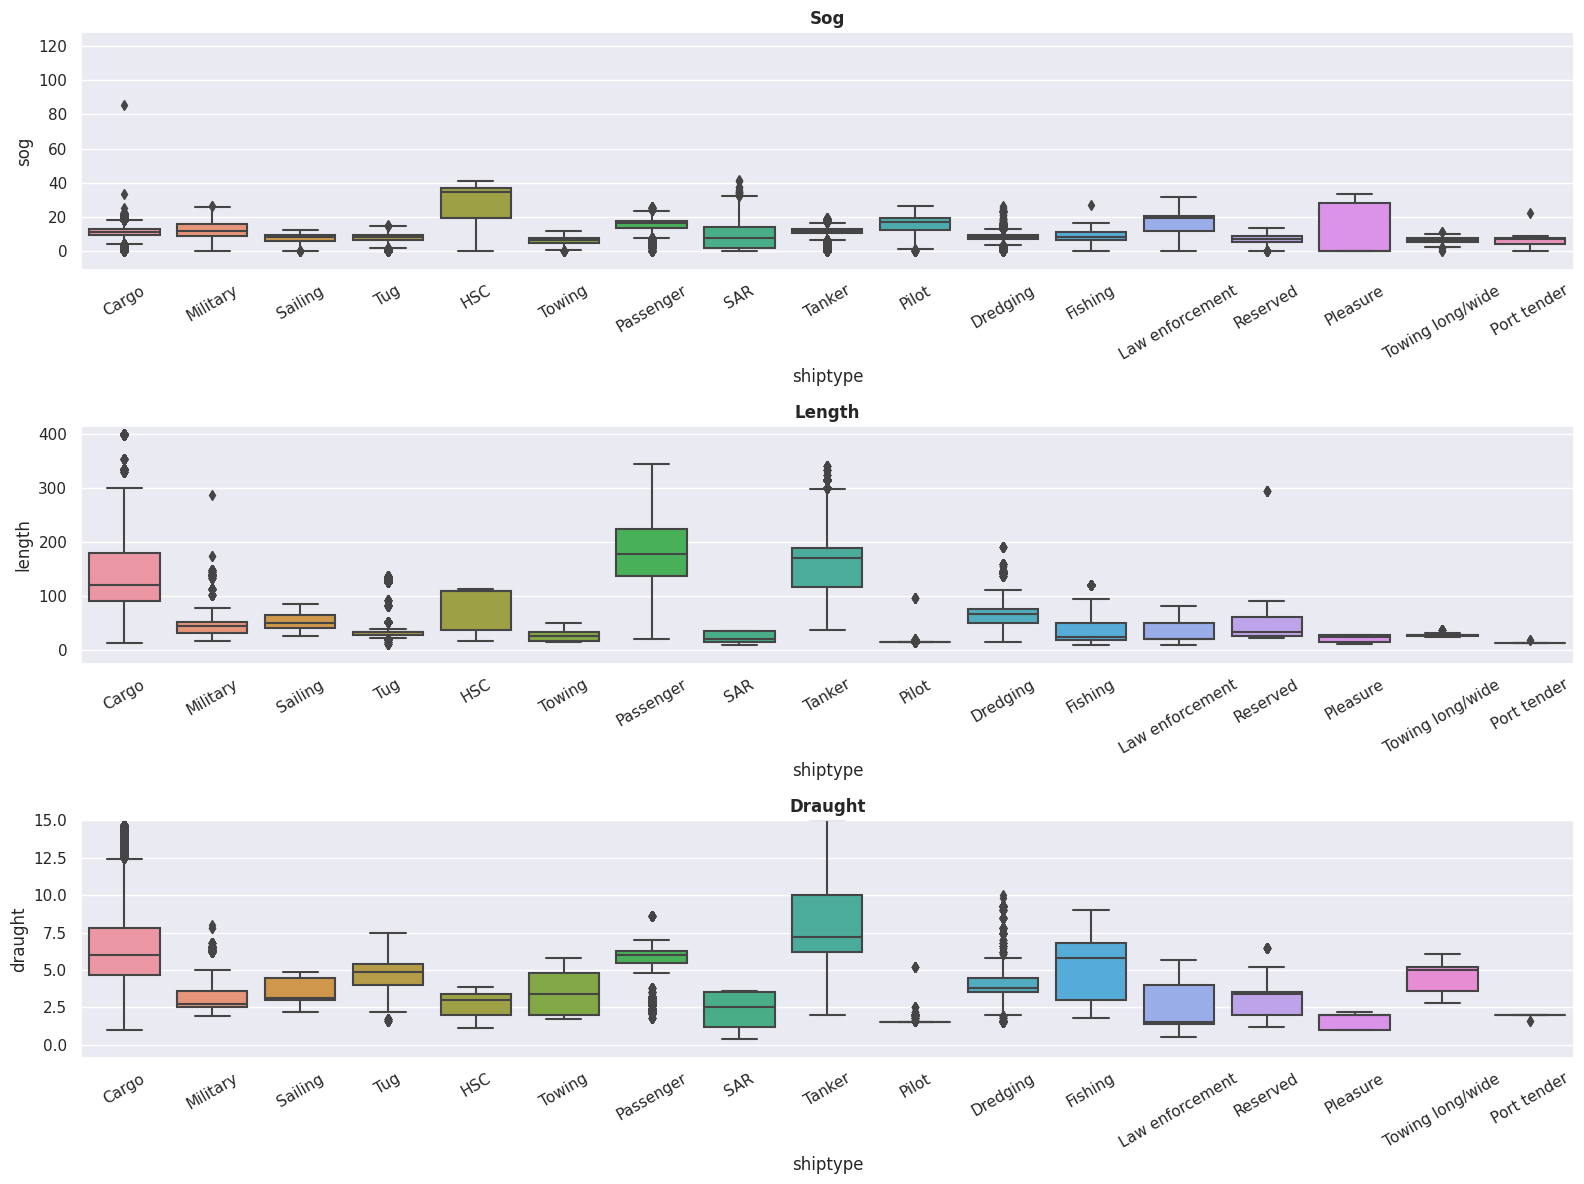

In [30]:
fig, axes = plt.subplots(3, 1, figsize=(16,12))


for i, col in enumerate(outlier_cols):
    ax = sns.boxplot(data=df, x='shiptype', y=col, ax=axes[i])
    ax.set_title(col.capitalize(), weight='bold')
    ax.set_ylim(top=int(df[col].max()*.6))
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
plt.tight_layout()

Now that the y axis has been adjusted we can clearly see the variation between ships for each of the variables. Observations are as follows:
- Sog: Without suprise, the HSB has the highest values
- Length: We can see that length appears to be a clear idendentifier of shiptype, especially in the larger ones such as Cargo, Passenger, and Tanker.
- Draught: Again, some clear variations between shiptypes with Carco, Passenger, and Tankr having the higher values

## Check distribution of shiptypes by navigational status

There is only one column (navigational status) that is of a categorical data type and therefore needs to be encoded (likely one-hot encoding). As there are 13 unique values, it is important to check if there is enough representation of ship types between these groups, as well as seeing if we can see any trends within them.

In [31]:
pd.DataFrame(df.groupby(['navigationalstatus', 'shiptype']).size()).head(60)

0
navigationalstatus                                 shiptype              
At anchor                                          Cargo              227
                                                   Dredging             9
                                                   Fishing              7
                                                   Law enforcement      1
                                                   Military             7
                                                   Reserved            24
                                                   SAR                  1
                                                   Tanker             212
                                                   Towing              14
                                                   Tug                  5
Constrained by her draught                         Cargo             5228
                                                   Dredging            27
                                                   Reserved            25
                                                   Tanker            6779
Engaged in fishing                                 Dredging             1
                                                   Fishing           5370
Moored                                             Cargo             1087
                                                   Dredging            88
                                                   Fishing            148
                                                   HSC                138
                                                   Law enforcement     21
                                                   Military           412
                                                   Passenger          221
                                                   Pilot               92
                                                   Pleasure            46
                                                   Port tender         52
                                                   Reserved            51
                                                   SAR                125
                                                   Sailing             14
                                                   Tanker             362
                                                   Towing              30
                                                   Towing long/wide     2
                                                   Tug                333
Not under command                                  Cargo                1
                                                   Military             1
                                                   Passenger            1
                                                   Tanker               1
                                                   Tug                  1
Power-driven vessel pushing ahead or towing alo... Cargo                1
                                                   Tug                234
Power-driven vessel towing astern                  Tug                246
Reserved for future amendment [HSC]                Fishing             87
                                                   HSC               1644
Restricted maneuverability                         Cargo                6
                                                   Dredging           181
                                                   Law enforcement     12
                                                   Military            18
                                                   Pilot                4
                                                   Reserved            72
                                                   SAR                  1
                                                   Towing             290
                                                   Towing long/wide   340
                                                   Tug                743
Un

Given more time, I would like to understand some of these status values in a bit more detail to see if any should be taken out of the model process and handled separately. The main one of concern would be the unknown value, which accounts for 17259 of the rows. Do we want the model(s) to learn from this or do we risk incorporating noise? Again, due to my limited expertise in the subject matter, the decision was made to leave it in.

## Analysis into the remaining variables

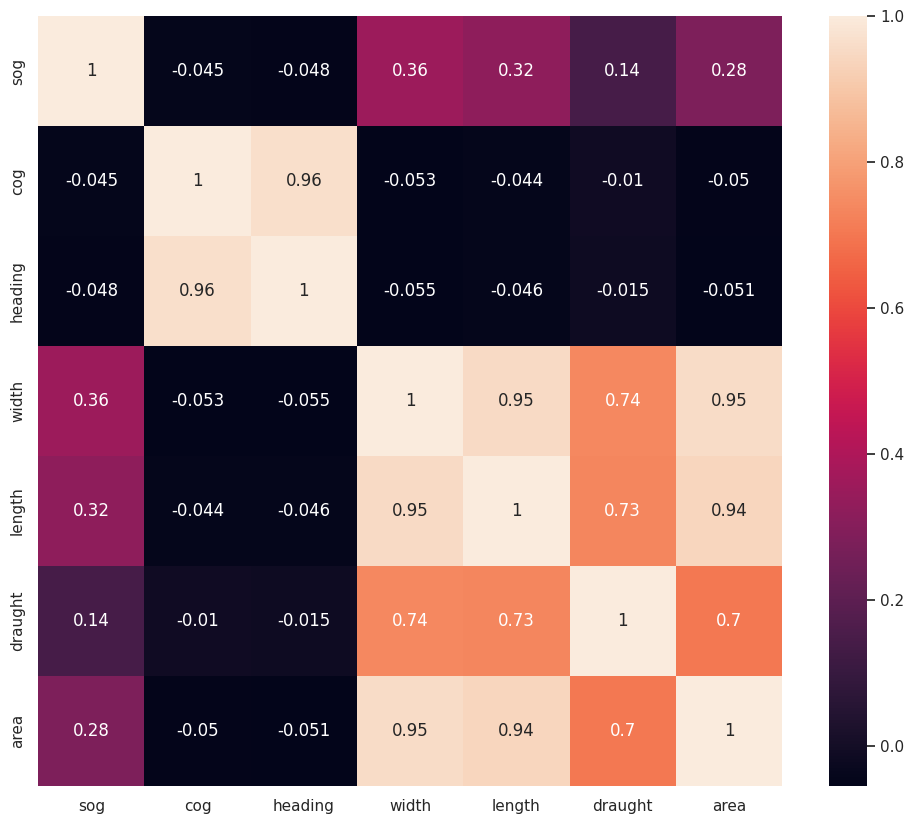

In [32]:
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()[1:]

plt.figure(figsize=(12,10))
sns.heatmap(df[numeric_columns].corr(), annot=True)
plt.show()

Some strong (yet unsurprising) correlations between the continuous variables, notably:
- Length, width, and area
- Draught against width, length and area
- Cog and heading

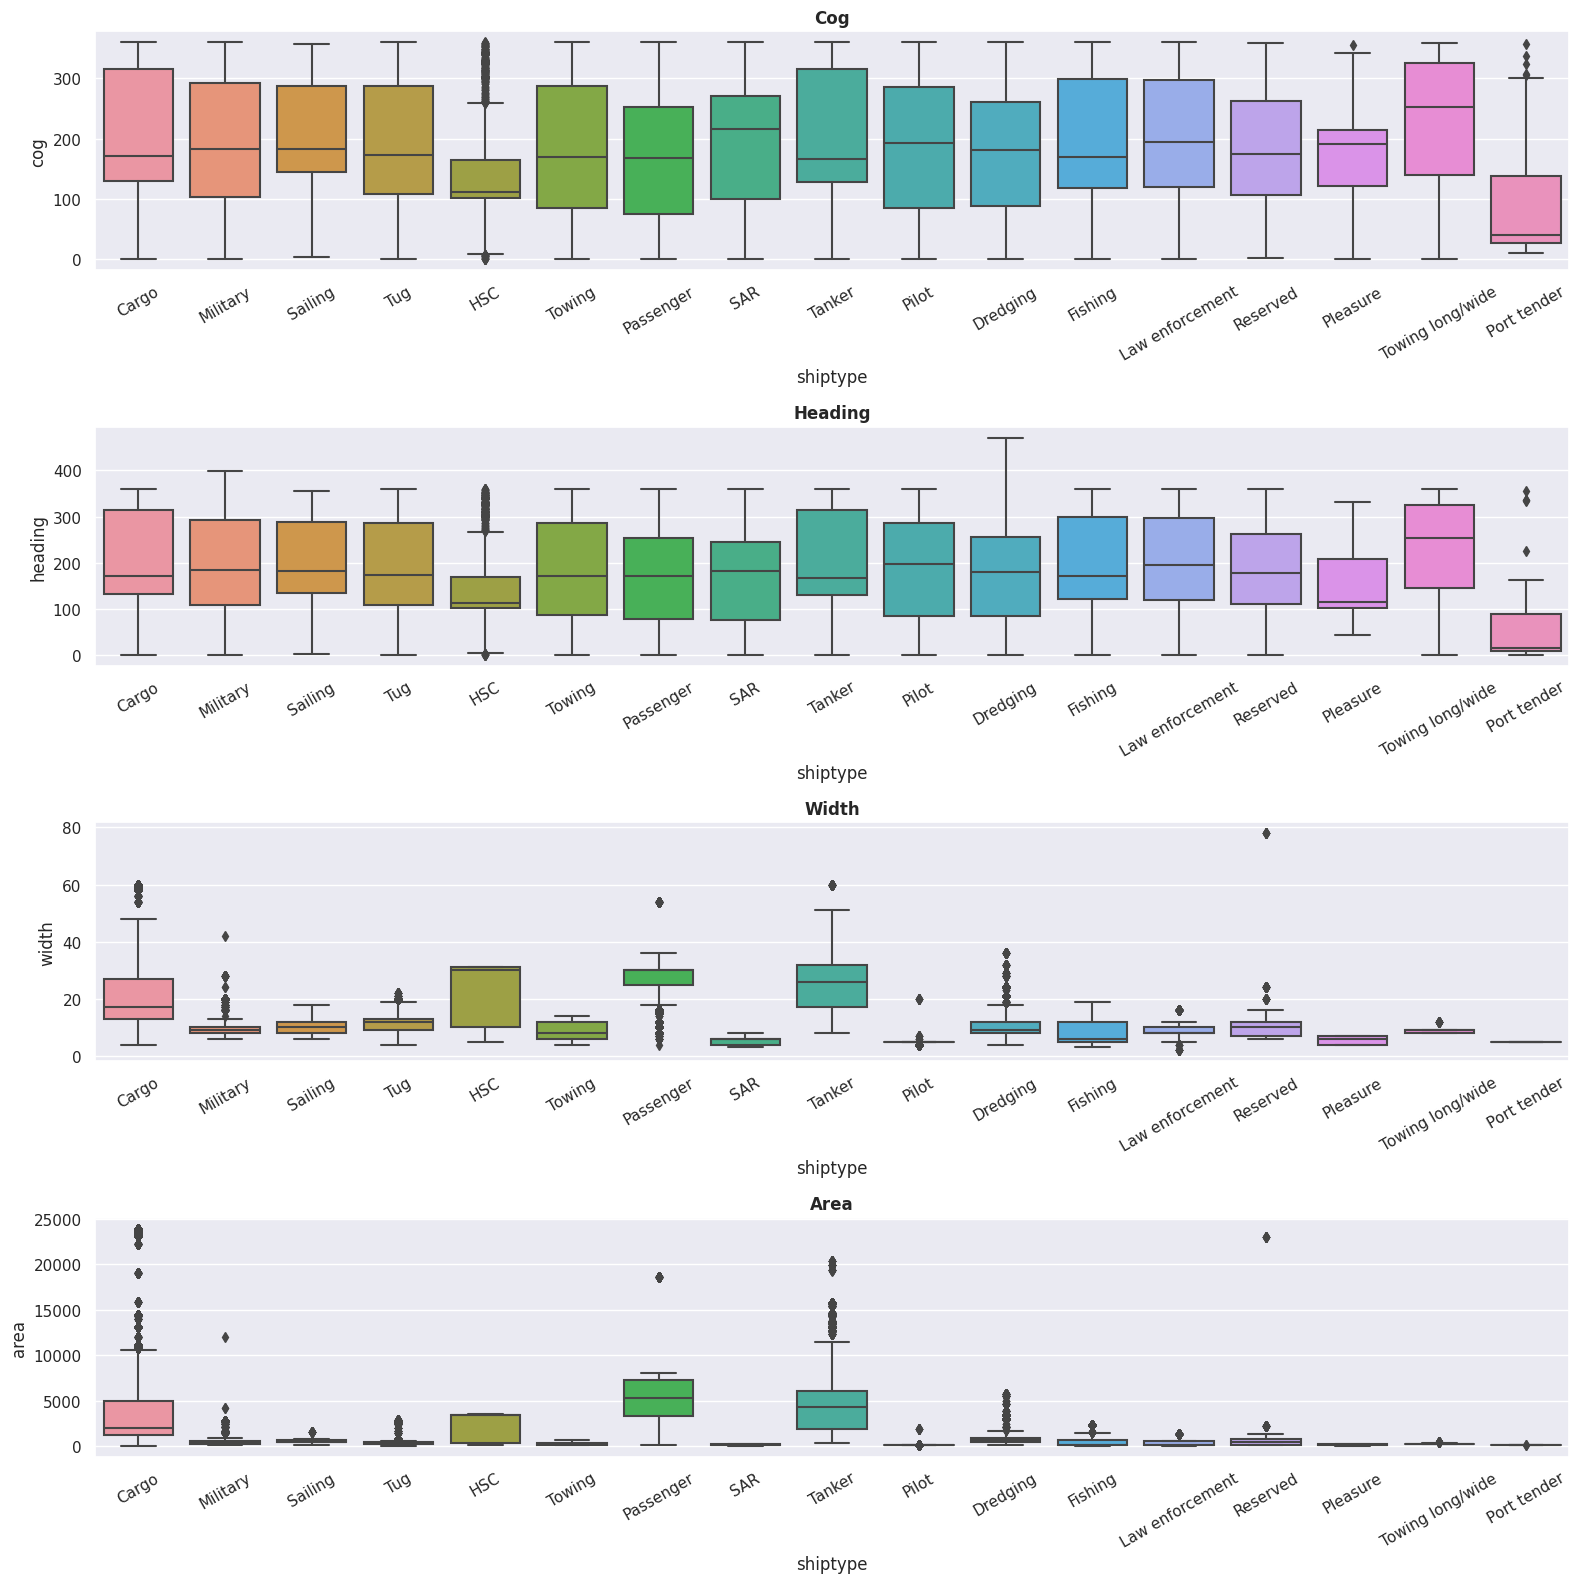

In [33]:
remaining_vars = ['cog', 'heading', 'width', 'area']

fig, axes = plt.subplots(4, 1, figsize=(16,16))


for i, col in enumerate(remaining_vars):
    ax = sns.boxplot(data=df, x='shiptype', y=col, ax=axes[i])
    ax.set_title(col.capitalize(), weight='bold')
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
plt.tight_layout()

It is clear from the above plots that width will be an important variable for the model(s), although there are some clear outliers shown in the Fishing and Pleasure ship types.
Cog appears to have the least variation between shiptypes with a median that does not seem to fluctuate much, however, the changes in the IQR show more of a fluctuation.

## Can we visualise clusters of ship type using PCA?

In [34]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

for_pca = df.dropna().sample(20000)

# Scale data
scaler = MinMaxScaler()

scaled_df = pd.DataFrame(scaler.fit_transform(for_pca[numeric_cols]), columns=numeric_cols)

In [35]:
# PCA
pca = PCA()
pca_df = pd.DataFrame(pca.fit_transform(scaled_df),
             columns=[f'PCA{n+1}' for n in range(pca.fit_transform(scaled_df).shape[1])])

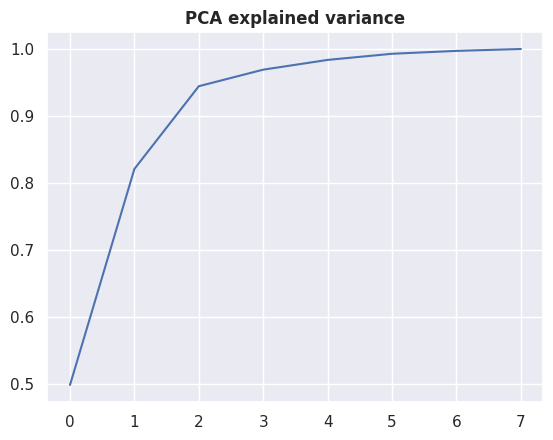

In [36]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA explained variance', weight='bold')
plt.show()

Plot shows that we are able to explain more than 90% of the variance using the first 2 components

In [37]:
pca_df_out = pd.concat([pca_df, for_pca['shiptype'].reset_index()], axis=1)

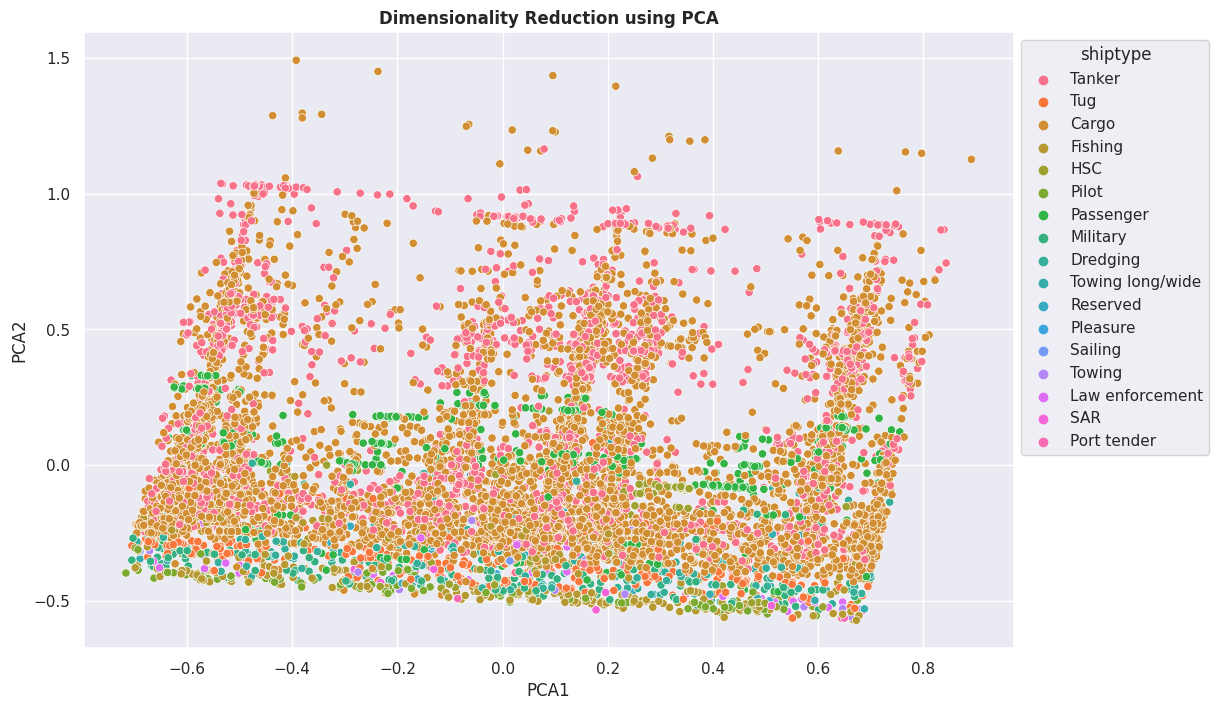

In [38]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(data=pca_df_out.sample(10000), x='PCA1', y='PCA2', hue='shiptype', legend=True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Dimensionality Reduction using PCA', weight='bold')

plt.show()

We see some clusters along the x-axis, however too difficult to visualise with PCA

In [67]:
#reducer = umap.UMAP()

In [69]:
#umap_reduced = reducer.fit_transform(scaled_df)

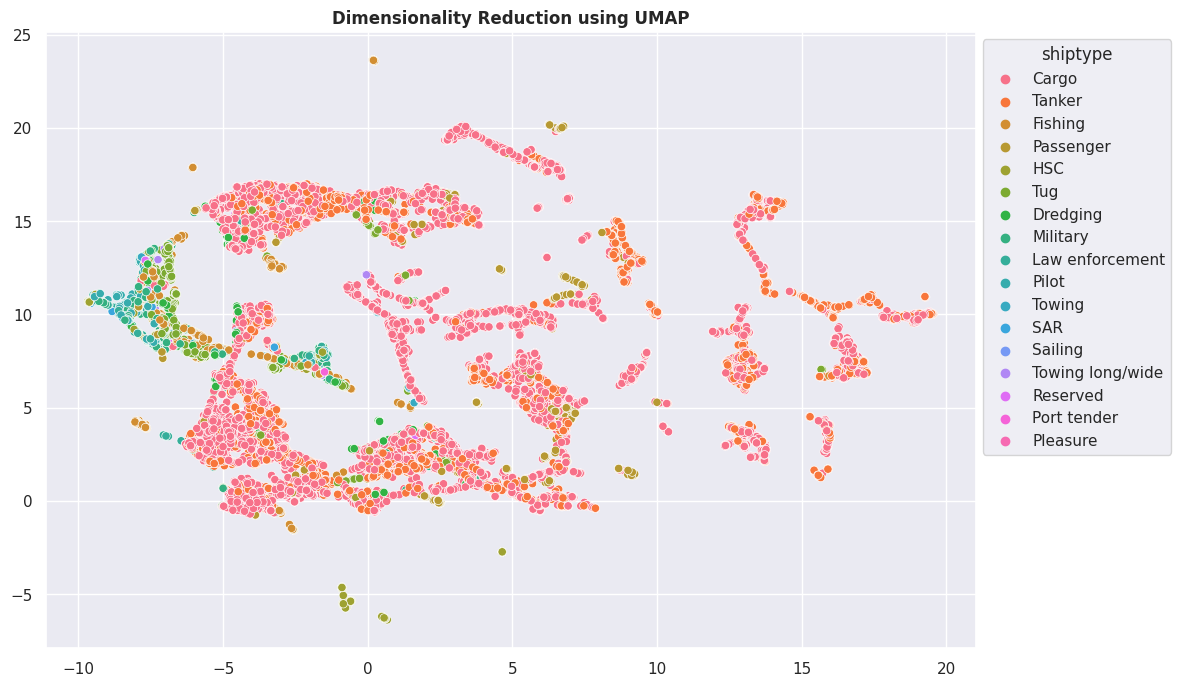

In [41]:
plt.figure(figsize=(12,8))

ax = sns.scatterplot(x=umap_reduced[:,0], y=umap_reduced[:,1], hue=for_pca.shiptype, legend=True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Dimensionality Reduction using UMAP', weight='bold')

plt.show()

Better separation than PCA, but still difficult to derive any clear groups within these clusters with the exception of Tankers and Cargo.

## Model selection

The performance metric used to tune and validate the models will be balanced accuracy. The metric gives a better indication of model performance where the response variable classes are imbalanced. For example, if the model decided to predict every ship as Cargo, then the accuracy would be at almost 60% giving a miscomprehention of the model performance.

The steps in choosing the best model will be as follows:
- Train a number of classifiers using default hyperparameters.
- Select the best one or two models (depending on the results) using 5-fold cross validation.
- Tune this best model(s) using a number of different hyperparameters.
- Select best combination of hyperparameters. Re-train on the training data and test the model on the serving set. Note - it is important we also validate with this serving set as it has been completely left out of the tuning process and best represents that of a real-world scenario.

**It must also be noted that, I would typically train more models for step 1 as well as hyperparameter tuning on more combinations. However, given the time constraints, I have to reduce this somewhat.**

In [40]:
df.shiptype

4             Cargo
5             Cargo
7             Cargo
8             Cargo
11         Military
            ...    
358345       Tanker
358346        Cargo
358347        Cargo
358348    Passenger
358350      Fishing
Name: shiptype, Length: 324561, dtype: object

In [41]:
# Define the resposne variable
response = 'shiptype'

# One-hot encode thee categorical columns
cat_col = ['navigationalstatus']
dummies = pd.get_dummies(df[cat_col], dtype=int)
processed_df = pd.concat([df, dummies], axis=1).drop(cat_col, axis=1)

# Rename column with non-standard characters
processed_df = processed_df.rename(columns={'navigationalstatus_Reserved for future amendment [HSC]':'navigationalstatus_Reserved for future amendment'})

In [42]:
# Serving set to be kept completely left out of the cross validation and model tuning process to bee used as final validation.
np.random.seed(1)
mmsi_validation = np.random.choice(processed_df.mmsi.unique(), int(len(processed_df.mmsi.unique())*.1))

# Scale data
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(processed_df.drop([response, 'mmsi'], axis=1))
scaled_df = pd.DataFrame(scaled_df, columns=processed_df.drop([response, 'mmsi'], axis=1).columns)
scaled_df = pd.concat([scaled_df, processed_df[[response, 'mmsi']].reset_index(drop=True)], axis=1)

# Encode the response variable
encoder = LabelEncoder()
scaled_df['shiptype_encode'] = encoder.fit_transform(scaled_df[response])

# Split training and serving df
serving_df = scaled_df[scaled_df.mmsi.isin(mmsi_validation)]
train_df = scaled_df[~scaled_df.mmsi.isin(mmsi_validation)]



In [43]:
# Check we have representation between the classes
serving_df.shiptype.value_counts()

shiptype
Cargo               21876
Tanker               9310
Fishing               708
Dredging              673
Military              523
Pilot                 480
Passenger             271
Tug                   115
HSC                    82
Sailing                15
Towing long/wide        1
Name: count, dtype: int64

In [44]:
serving_df.shiptype_encode.value_counts()

shiptype_encode
0     21876
13     9310
2       708
1       673
5       523
7       480
6       271
16      115
3        82
12       15
15        1
Name: count, dtype: int64

In [45]:
response = 'shiptype_encode'
drop_cols = [response, 'mmsi', 'shiptype']

X = train_df.drop(drop_cols, axis=1)
y = train_df[response]

X_serving = serving_df.drop(drop_cols, axis=1)
y_serving = serving_df[response]

## Shortlist best model(s) - single split, out of box hyperparameters

In [46]:
## Split train and test
np.random.seed(1)
mmsi_test = np.random.choice(train_df.mmsi.unique(), int(len(train_df.mmsi.unique())*.2))

# Ensure train and test do not contain the same vessel
test = train_df[train_df.mmsi.isin(mmsi_test)]
train = train_df[~train_df.mmsi.isin(mmsi_test)]

X = train.drop(drop_cols, axis=1)
y = train[response]

X_test = test.drop(drop_cols, axis=1)
y_test = test[response]

In [47]:
# Define classifiers to test
classifiers = [
    RandomForestClassifier(),
    #MLPClassifier(),
    GradientBoostingClassifier(),
    #GaussianNB(),
    #LinearDiscriminantAnalysis(),
    xgb.XGBClassifier(),
    RandomForestClassifier(bootstrap=True)
]

In [49]:
bal_acc_res = list()
acc_res = list()

# Train and log results for each of the classifiers
for mod in classifiers:
    t1 = time.time()

    try:
        print(f"Training classifier: {mod}")
        mod.fit(X, y)
        pred = mod.predict(X_test)
        bal_acc = balanced_accuracy_score(y_test, pred)
        acc = accuracy_score(y_test, pred)
        bal_acc_res.append(bal_acc)
        acc_res.append(acc)
        print(f"Balanced accuracy: {bal_acc}, accuracy: {acc}, time to train model: {time.time()-t1}")

    except Exception as e:
        print(e)
        print(f"Error in {mod}")




Training classifier: RandomForestClassifier()
Balanced accuracy: 0.5498153323649866, accuracy: 0.8472808449171778, time to train model: 59.494426012039185
Training classifier: GradientBoostingClassifier()
Balanced accuracy: 0.22991168944016935, accuracy: 0.06758962237604818, time to train model: 1095.803605556488
Training classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, 

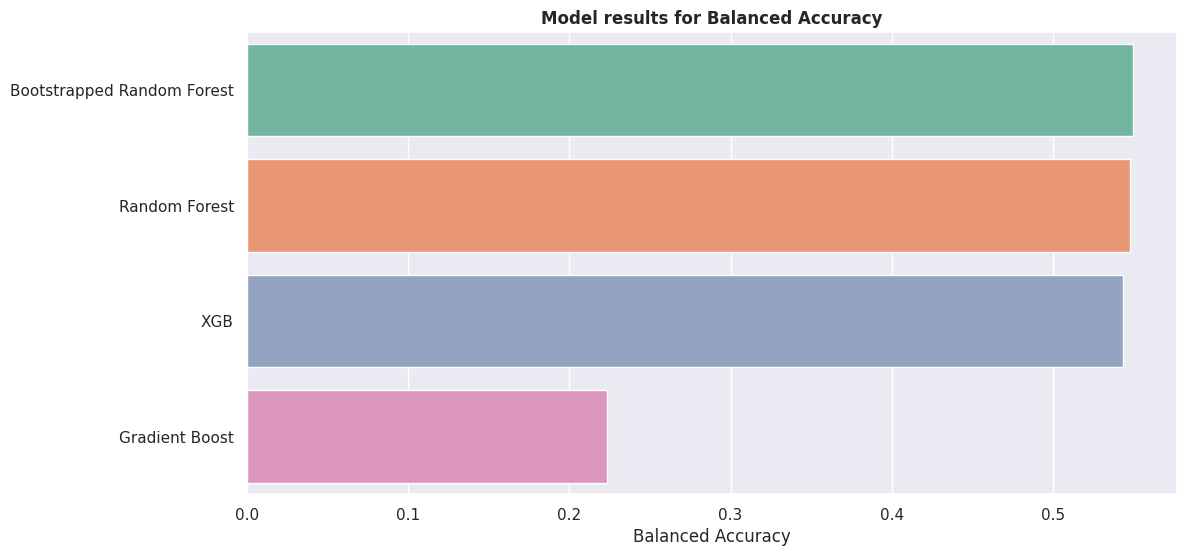

In [51]:
names = [
    'Random Forest',
    #'MLP',
    'Gradient Boost',
    #'Gaussian NB',
    #'LDA',
    'XGB',
    'Bootstrapped Random Forest'
]

results = pd.DataFrame(bal_acc_res, index=names)

results = results.set_axis(['Balanced Accuracy'], axis=1, copy=False).sort_values(by='Balanced Accuracy', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=results['Balanced Accuracy'], y=results.index, palette='Set2')
plt.title('Model results for Balanced Accuracy', weight='bold')

plt.show()

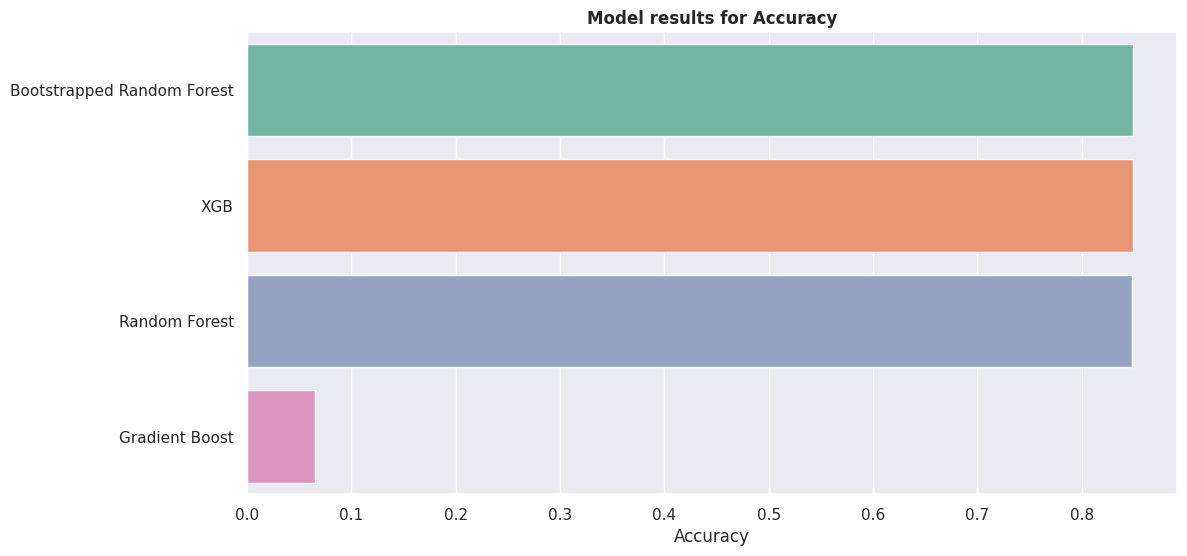

In [52]:
results = pd.DataFrame(acc_res, index=names)

results = results.set_axis(['Accuracy'], axis=1, copy=False).sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=results['Accuracy'], y=results.index, palette='Set2')
plt.title('Model results for Accuracy', weight='bold')


plt.show()

The out of box results show Random forest having both highest balanced accuracy (approx. 55%) and accuracy (approx. 85%)

## Tune best model

In [53]:
# Define model hyperparameter function
def tune_best_model(train_df: pd.DataFrame,
                    params: dict[str, Any],
                    drop_cols: list[str],
                    response: str = 'shiptype_encode',
                    group: str = 'mmsi',
                    scoring_metric: str = 'balanced_accuracy') -> dict[str, Any]:
    """Function to tune model and return best results and params

    Args:
        train_df (pd.DataFrame): Training data
        params (dict[str, Any]): Parameters to tune
        drop_cols (list[str]): Columns to drop
        response (str, optional): Response variable. Defaults to 'shiptype_encode'.
        group (str, optional): Variable to use for the grouped k-fold.
        Defaults to 'mmsi'.
        scoring_metric (str, optional): Performance metric. Defaults to 'balanced_accuracy'.

    Returns:
        dict[str, Any]: results dictionary
    """

    # Define groups for group k-fold
    groups = train_df[group]

    X = train_df.drop(drop_cols, axis=1)
    y = train_df[response]

    # Grouped 5-fold CV
    gkf = GroupKFold(n_splits=5)
    gkf.get_n_splits(X, y, groups)

    print(f"Tuning models for {response} with {len(train_df)} training rows")

    # Define sample weights since we are dealing with a significant imbalance between classes
    samp_weights = compute_sample_weight(class_weight='balanced', y=y)

    rf_cv = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid=params,
        cv=gkf,
        verbose=10,
        scoring=scoring_metric,
    )

    rf_cv.fit(X, y, groups=groups, sample_weight=samp_weights)

    results = dict(
        {
            f"scores_{response}": rf_cv.best_score_,
            f"params_{response}": rf_cv.best_params_
        }
    )

    return results

In [54]:
params = {'max_depth': [None, 4,5,6, 7, 8, 9, 10],
         'n_estimators': [50, 100, 200]}

results = tune_best_model(train_df, params=params, drop_cols=drop_cols)

Tuning models for shiptype_encode with 290507 training rows
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START max_depth=None, n_estimators=50............................
[CV 1/5; 1/24] END max_depth=None, n_estimators=50;, score=0.560 total time=  23.7s
[CV 2/5; 1/24] START max_depth=None, n_estimators=50............................
[CV 2/5; 1/24] END max_depth=None, n_estimators=50;, score=0.465 total time=  23.5s
[CV 3/5; 1/24] START max_depth=None, n_estimators=50............................
[CV 3/5; 1/24] END max_depth=None, n_estimators=50;, score=0.519 total time=  21.9s
[CV 4/5; 1/24] START max_depth=None, n_estimators=50............................
[CV 4/5; 1/24] END max_depth=None, n_estimators=50;, score=0.383 total time=  23.0s
[CV 5/5; 1/24] START max_depth=None, n_estimators=50............................
[CV 5/5; 1/24] END max_depth=None, n_estimators=50;, score=0.432 total time=  22.2s
[CV 1/5; 2/24] START max_depth=None, n_estimators=100

Cross validation score with hyperparameters max depth:9 and n estimators:50 = Balanced accuracy 48.3%

## Evaluate model with best hyperparameters on serving set

In [55]:
best_params = {'max_depth': 9, 'n_estimators': 50}

In [56]:
X = train_df.drop(drop_cols, axis=1)
y = train_df[response]

samp_weights = compute_sample_weight(class_weight='balanced', y=y)
mod = RandomForestClassifier(**best_params)
mod.fit(X, y, samp_weights)

RandomForestClassifier(max_depth=9, n_estimators=50)

In [57]:
X_serving = serving_df.drop(drop_cols, axis=1)
y_serving = serving_df[response]

In [58]:
preds = mod.predict(X_serving)

In [59]:
probs = mod.predict_proba(X_serving)

In [60]:
acc = accuracy_score(y_serving, preds)
bal_acc = balanced_accuracy_score(y_serving, preds)

print(f"Results on serving set, balanced accuracy={bal_acc}, accuraqcy={acc}")

Results on serving set, balanced accuracy=0.536706250854771, accuraqcy=0.6290890937922123


In [61]:
acc = accuracy_score(y_serving, preds)
bal_acc = balanced_accuracy_score(y_serving, preds)

print(f"Results on serving set, balanced accuracy={bal_acc}, accuraqcy={acc}")

Results on serving set, balanced accuracy=0.536706250854771, accuraqcy=0.6290890937922123


## Feature Importance

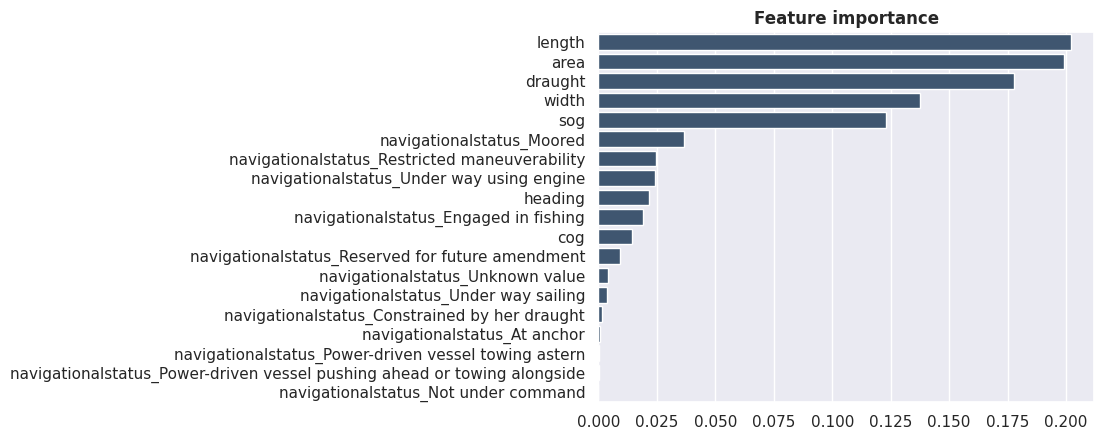

In [62]:
# Extract feature importance
feat_imp = pd.Series(mod.feature_importances_, X.columns).sort_values(
    ascending=False
)
# # Remove columns which provide no benefit to the model
# feat_imp = feat_imp[feat_imp > 0.01]
feat_df = pd.DataFrame(feat_imp.values, feat_imp.index)

sns.barplot(x=feat_imp.values, y=feat_imp.index, color="#375578")
plt.title(f"Feature importance", weight="bold")
plt.show()

> ## Additional validation is to understand how confident the model is predicting the classes

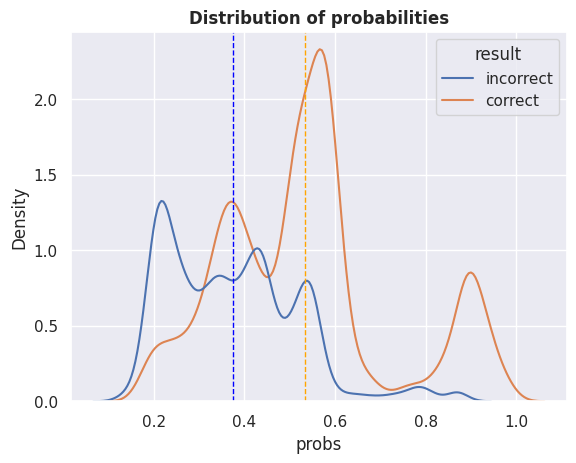

In [63]:
results_df = pd.DataFrame(
            {
                "ground_truth": serving_df[response],
                "ground_truth_orig": serving_df['shiptype'],
                "pred": preds,
                "probs": [prob[pred] for (pred, prob) in zip(preds, probs)]
            }
        )

results_df['result'] = results_df.apply(lambda x: 'correct' if x.ground_truth==x.pred else 'incorrect', axis=1)

sns.kdeplot(data=results_df, x="probs", hue='result')
plt.axvline(results_df[results_df.result=='correct'].probs.mean(), c="orange", ls="--", lw=1)
plt.axvline(results_df[results_df.result=='incorrect'].probs.mean(), c="blue", ls="--", lw=1)
plt.title("Distribution of probabilities", weight="bold")
plt.show()

The above probability plot illustrates the distribution of probabilities for the predictions the model gets correct compared to the predictions it makes that are incorrect. The model is both predicting with high confidence as well as showing a significant difference between the ones it gets correct opposed to what it gets incorrect.

## Lastly, get results for each class

In [64]:
acc_list = list()

for ship in results_df.ground_truth_orig.unique():
    ship_res = results_df[results_df.ground_truth_orig==ship]
    acc = accuracy_score(ship_res.ground_truth, ship_res.pred)
    acc_list.append(acc)

    print(f"Results for {ship}, accuracy:{round(acc, 2)}, count:{len(ship_res)}")



Results for Cargo, accuracy:0.59, count:21876
Results for Military, accuracy:0.1, count:523
Results for Tanker, accuracy:0.72, count:9310
Results for HSC, accuracy:0.59, count:82
Results for Pilot, accuracy:1.0, count:480
Results for Passenger, accuracy:0.89, count:271
Results for Dredging, accuracy:0.54, count:673
Results for Fishing, accuracy:0.79, count:708
Results for Towing long/wide, accuracy:0.0, count:1
Results for Tug, accuracy:0.37, count:115
Results for Sailing, accuracy:0.33, count:15


In [65]:
results

{'scores_shiptype_encode': 0.5099232888361069,
 'params_shiptype_encode': {'max_depth': 10, 'n_estimators': 50}}

In [66]:
df

,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,area
4,212584000,Moored,0.0,153.0,106.0,Cargo,13.0,99.0,6.3,1287.0
5,636020662,At anchor,0.1,43.9,286.0,Cargo,23.0,149.0,6.3,3427.0
7,246539000,At anchor,0.0,3.8,293.0,Cargo,16.0,150.0,6.8,2400.0
8,210307000,Moored,0.0,285.1,225.0,Cargo,16.0,90.0,5.2,1440.0
11,219263000,Moored,0.0,353.9,100.0,Military,12.0,48.0,4.2,576.0
...,...,...,...,...,...,...,...,...,...,...
358345,266475000,Under way using engine,11.2,92.4,90.0,Tanker,17.0,120.0,6.7,2040.0
358346,236125000,Under way using engine,11.0,171.9,169.0,Cargo,12.0,82.0,4.2,984.0
358347,209717000,Under way using engine,16.6,341.6,343.0,Cargo,27.0,170.0,8.9,4590.0
358348,257182000,Under way using engine,20.6,340.7,341.0,Passenger,36.0,224.0,6.9,8064.0


In [67]:
results = pd.DataFrame(acc_list, index=results_df.ground_truth_orig.unique())
results = results.set_axis(['Accuracy'], axis=1, copy=False).sort_values(by='Accuracy', ascending=False)

count_all = list()
count_serving = list()

for ship in results.index:
    count_all.append(len(df[df.shiptype==ship]))
    count_serving.append(len(results_df[results_df.ground_truth_orig==ship]))

results['count_all'] = count_all
results['count_serving'] = count_serving

results

,Accuracy,count_all,count_serving
Pilot,1.000000,2902,480
Passenger,0.885609,16778,271
Fishing,0.786723,12110,708
Tanker,0.717186,77405,9310
Cargo,0.592384,186699,21876
HSC,0.585366,3694,82
Dredging,0.542348,5109,673
Tug,0.365217,9410,115
Sailing,0.333333,157,15
Military,0.095602,6073,523


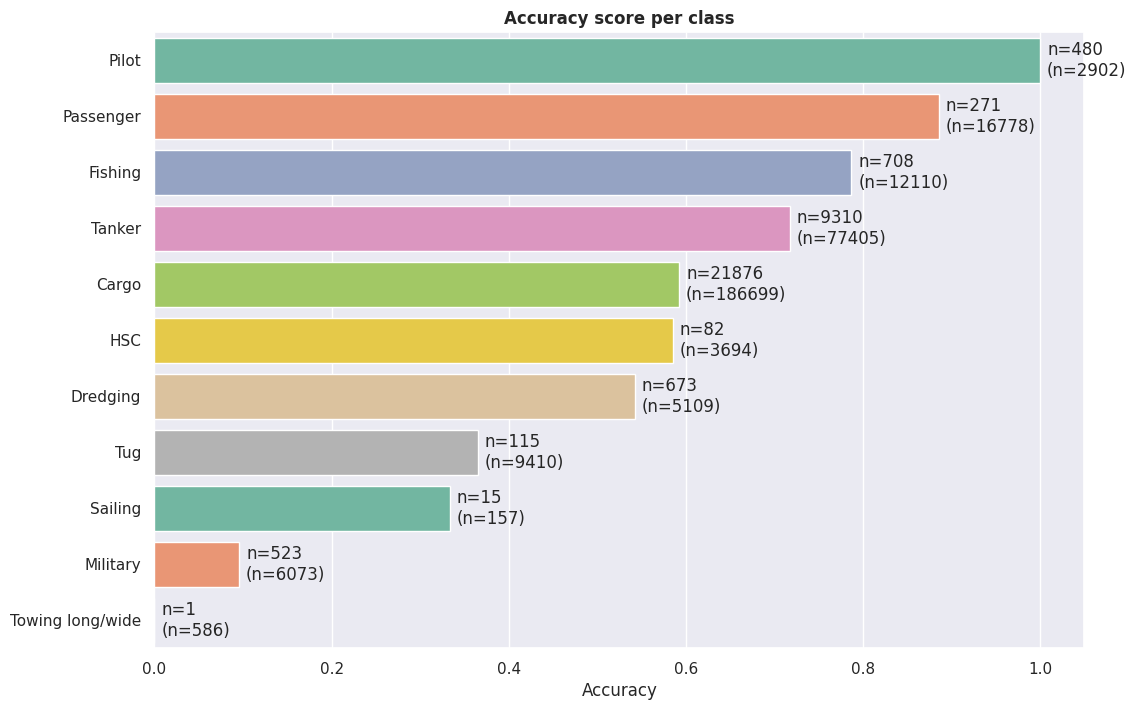

In [68]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x=results['Accuracy'], y=results.index, palette='Set2')

for p, count, count_train in zip(ax.patches, results.count_serving,results.count_all):
    ax.annotate(f"n={count}\n(n={count_train})", xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

plt.title('Accuracy score per class', weight='bold')

plt.show()

In [2]:
!pip install optuna

In [3]:
# importing libraries
import lightgbm as lgb
import optuna

In [50]:
model = lgb.LGBMClassifier() # instantiates model
model.fit(X, y) # parameter estimation

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1472
[LightGBM] [Info] Number of data points in the train set: 237200, number of used features: 18
[LightGBM] [Info] Start training from score -0.549587
[LightGBM] [Info] Start training from score -4.170075
[LightGBM] [Info] Start training from score -3.137440
[LightGBM] [Info] Start training from score -4.418432
[LightGBM] [Info] Start training from score -5.163627
[LightGBM] [Info] Start training from score -4.143953
[LightGBM] [Info] Start training from score -2.968206
[LightGBM] [Info] Start training from score -4.696022
[LightGBM] [Info] Start training from score -8.059171
[LightGBM] [Info] Start training from score -8.406367
[LightGBM] [Info] Start training from score -6.228191
[LightGBM] [Info] Start training 

LGBMClassifier()

In [51]:
# defining objective function for optimization
def objective(trial):
  # parameter grid to search - using recommend ranges from article I read last semester for CS 301
  param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
  }
  # creates model to try hyperparameter combination sets
  model = lgb.LGBMClassifier(**param_grid)
  # fits the model to the data with a single candidate set
  model.fit(X, y)
  # generates predictions using this model
  pred = model.predict(X_test)
  # scores the predictions based on accuracy score
  acc = accuracy_score(y_test, pred)
  return 1 - acc

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1)
print("Best trial:", study.best_trial.params)

[I 2023-10-09 08:20:56,884] A new study created in memory with name: no-name-93e202ad-5edf-43dd-b789-db9f494caadc


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
# fitting model with tuned hyperparameters, making and evaluating predictions to compare it to Random Forest Classifier
model = lgb.LGBMClassifier()
model.fit(X, y)
pred = model.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f"Tuned LightGBM Model Accuracy: {acc}")